# <center>Phase 2 - Publication<center>

In [2]:
# General imports.
import sqlite3
import pandas as pd
from matplotlib_venn import venn2, venn3
import scipy.stats as scs
import textwrap
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from  itertools import combinations
import os
from matplotlib.colors import ListedColormap
from matplotlib import ticker
from scipy.stats import ttest_ind
import math
from timeit import default_timer as timer

# Imports from neighbor directories.
import sys
sys.path.append("..")
from src.utilities import field_registry as fieldreg

# IPython magics for this notebook.
%matplotlib inline

# Use latex font for matplotlib
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
# Switches
SAVE_OUTPUT = False

# Data Globals
FR = fieldreg.FieldRegistry()
TOTAL_USERS = 0
REMAINING_USERS = 0
TOTAL_DOGS = 0
REMAINING_DOGS = 0
PREVALENCE = lambda x: (x / REMAINING_DOGS) * 100
CATEGORY_MATRIX = pd.DataFrame()

# Database Globals
USER_TABLE = 'users'
DOG_TABLE = 'dogs'
BIAS_FILTER = '''
    USING (record_id)
    WHERE question_reason_for_part_3 = 0
    OR (question_reason_for_part_3 = 1 AND q01_main != 1)'''
CON = sqlite3.connect('../data/processed/processed.db')

In [4]:
def createStringDataFrame(table, fields, labels, filtered=True):
    query = 'SELECT ' + fields + ' FROM ' + table
    if filtered:
        table2 = USER_TABLE if table == DOG_TABLE else DOG_TABLE
        query += ' JOIN ' + table2 + ' ' + BIAS_FILTER
    df = pd.read_sql_query(query, CON)
    df.columns = labels
    return df

def convertToNumeric(df):
    df = df.apply(pd.to_numeric, errors='coerce')
    return df

def createNumericDataFrame(table, fields, labels, filtered=True):
    df = createStringDataFrame(table, fields, labels, filtered)
    return convertToNumeric(df)

def replaceFields(df, column, replacement_dict):
    df[column].replace(replacement_dict, inplace=True)

def getValueCountAndPrevalence(df, field):
    s = df[field].value_counts()
    p = s.apply(PREVALENCE).round().astype(int)
    rv = pd.concat([s, p], axis=1)
    rv.columns = ['frequency', 'prevalence']
    return rv

def createCategoryMatrix():
    fields = []
    labels = []
    counter = 1
    for cat, subdict in FR.labels.items():
        for key, value in  subdict.items():
            if counter == 11:
                counter += 1;
            fields.append('q02_main_{}'.format(counter))
            labels.append(key[0])
            break
        counter += 1
    fields = ', '.join(fields)
    df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    cols = []
    pvalue = {}
    for col in df:
        cols.append(col)
        pvalue[col] = {}
    pairs = list(combinations(df.columns, 2))
    for pair in pairs:
        contingency = pd.crosstab(df[pair[0]], df[pair[1]])
        c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
        pvalue[pair[0]][pair[1]] = p
        pvalue[pair[1]][pair[0]] = p
    df = pd.DataFrame(pvalue).sort_index(ascending=True)
    return df

def createQuestionMatrix():
    fields = ''
    for cat, sublist in FR.fields.items():
        for field in sublist:
            fields += '{}, '.format(field)
    fields = fields[:-2]
    labels = []
    for cat, subdict in FR.labels.items():
        for key, value in  subdict.items():
            labels.append(key)
    df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    cols = []
    pvalue = {}
    for col in df:
        cols.append(col)
        pvalue[col] = {}
    pairs = list(combinations(df.columns, 2))
    for pair in pairs:
        contingency = pd.crosstab(df[pair[0]], df[pair[1]])
        c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
        pvalue[pair[0]][pair[1]] = p
        pvalue[pair[1]][pair[0]] = p
    df = pd.DataFrame(pvalue).sort_index(ascending=True)
    return df

def createCorrelationMatrix():
    fields = []
    labels = []
    counter = 1
    for cat, subdict in FR.labels.items():
        for key, value in  subdict.items():
            if counter == 11:
                counter += 1;
            fields.append('q02_main_{}'.format(counter))
            labels.append(key[0])
            break
        counter += 1
    fields = ', '.join(fields)
    df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    return df.corr()

def createOddsRatioMatrix():
    fields = []
    labels = []
    counter = 1
    for cat, subdict in FR.labels.items():
        for key, value in  subdict.items():
            if counter == 11:
                counter += 1;
            fields.append('q02_main_{}'.format(counter))
            labels.append(key[0])
            break
        counter += 1
    fields = ', '.join(fields)
    df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    cols = []
    pvalue = {}
    for col in df:
        cols.append(col)
        pvalue[col] = {}
    pairs = list(combinations(df.columns, 2))
    for pair in pairs:
        contingency = pd.crosstab(df[pair[0]], df[pair[1]])
        c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
        pvalue[pair[0]][pair[1]] = getOddsRatio(contingency)
        pvalue[pair[1]][pair[0]] = getOddsRatio(contingency)
    df = pd.DataFrame(pvalue).sort_index(ascending=True)
    return df

def displayOddsRatio(df):
    odds, ci_low, ci_high, tot = getOddsRatioAndConfidenceInterval(df)
    print('OR = %.2f, 95%% CI: %.2f-%.2f, n = %d'
          %(round(odds, 2), round(ci_low, 2), round(ci_high, 2), tot))

def getOddsRatio(df):
    return (df[1][1]/df[1][0])/(df[0][1]/df[0][0])

def getOddsRatioAndConfidenceInterval(df):
    odds = getOddsRatio(df)
    nl_or = math.log(odds)
    se_nl_or = math.sqrt((1/df[0][0])+(1/df[0][1])+(1/df[1][0])+(1/df[1][1]))
    ci_low = math.exp(nl_or - (1.96 * se_nl_or))
    ci_high = math.exp(nl_or + (1.96 * se_nl_or))
    tot = df[0][0] + df[0][1] + df[1][0] + df[1][1]
    return odds, ci_low, ci_high, tot

def get_significance_category(p):
    if np.isnan(p):
        return p
    elif p > 10**(-3):
        return -1
    elif p <= 10**(-3) and p > 10**(-6):
        return 0
    else:
        return 1
    
def displaySeriesMedian(s, units=""):
    print('MD = %.2f %s (SD = %.2f, min = %.2f, max = %.2f, n = %d)'
          %(round(s.median(), 2), units, round(s.std(), 2), round(s.min(), 2), round(s.max(), 2), s.count()))
    
def displaySeriesMean(s, units=""):
    print('M = %.2f %s (SD = %.2f, min = %.2f, max = %.2f, n = %d)'
          %(round(s.mean(), 2), units, round(s.std(), 2), round(s.min(), 2), round(s.max(), 2), s.count()))
    
def convert_to_binary_response(x, y=1):
    x = float(x)
    if x < y:
        return 0
    return 1
        
def exportTable(data, title):
    if not SAVE_OUTPUT:
        return
    file_ = os.path.join('..', 'reports', 'tables', title) + '.tex'
    with open(file_, 'w') as tf:
        tf.write(r'\documentclass[varwidth=\maxdimen]{standalone}\usepackage{booktabs}\begin{document}')
        tf.write(df.to_latex())
        tf.write(r'\end{document}')
        
def exportFigure(figure, title):
    if not SAVE_OUTPUT:
        return
    file_ = os.path.join('..', 'reports', 'figures', title) + '.pdf'
    figure.tight_layout()
    figure.savefig(file_, format='pdf')

## <center>Demographics</center>

### Number of participants:

In [5]:
df = createNumericDataFrame(USER_TABLE, 'COUNT(*)', ['count'], filtered=False)
# Assign value to global.
TOTAL_USERS = df['count'][0]
print('N = %d owners [unadjusted]' %TOTAL_USERS)

N = 3201 owners [unadjusted]


### Number of participating dogs:

In [6]:
df = createNumericDataFrame(DOG_TABLE, 'COUNT(*)', ['count'], filtered=False)
# Assign value to global.
TOTAL_DOGS = df['count'][0]
print('N = %d dogs [unadjusted]' %TOTAL_DOGS)

N = 5018 dogs [unadjusted]


### Suspicion of behavior problems as one of multiple motivating factors:

In [7]:
fields = ('question_reason_for_part_1, question_reason_for_part_2, '
          'question_reason_for_part_3, question_reason_for_part_4, '
          'question_reason_for_part_5')
labels = ['love for dogs', 'you help shelter animals', 'suspicion of behavior problems',
          'work with animals', 'other']
df = createNumericDataFrame(USER_TABLE, fields, labels, filtered=False)
df = df[df[labels[2]] == 1]
df['sum'] = df.sum(axis=1)
s = df.sum(0, skipna=False)

print('n = %d owners (%d%%) [unadjusted]' %(s.iloc[2], round((s.iloc[2]/TOTAL_USERS)*100, 0)))

n = 830 owners (26%) [unadjusted]


### Suspicion of behavior problems as the sole motivating factor:

In [8]:
fields = ('question_reason_for_part_1, question_reason_for_part_2, '
          'question_reason_for_part_3, question_reason_for_part_4, '
          'question_reason_for_part_5')
labels = ['love for dogs', 'you help shelter animals', 'suspicion of behavior problems',
          'work with animals', 'other']
df = createNumericDataFrame(USER_TABLE, fields, labels, filtered=False)
df = df[df[labels[2]] == 1]
df['sum'] = df.sum(axis=1)
df = df[df['sum'] == 1]
s = df.sum(0, skipna=False)

print('n = %d owners (%d%%) [unadjusted]' %(s.iloc[2], round((s.iloc[2]/TOTAL_USERS)*100, 0)))

n = 98 owners (3%) [unadjusted]


### Adjusting sample for bias:

In [9]:
fields = 'q02_score'
labels = ['Score']
df_adjusted_dogs = createNumericDataFrame(DOG_TABLE, fields, labels)
REMAINING_DOGS = len(df_adjusted_dogs.index)
df_adjusted_users = createNumericDataFrame(USER_TABLE, 'COUNT(DISTINCT email)', ['count'])
REMAINING_USERS = df_adjusted_users['count'][0]

# Display the count results.
print('Adjusted study population:')
print('N = %d owners (adjusted)' %REMAINING_USERS)
print('N = %d dogs (adjusted)' %REMAINING_DOGS)

Adjusted study population:
N = 2480 owners (adjusted)
N = 4114 dogs (adjusted)


### Dogs per household:

In [10]:
fields = 'record_id'
labels = ['record index']
df = createStringDataFrame(DOG_TABLE, fields, labels)

record_dict = {}
for index, row in df.iterrows():
    key = row.iloc[0]
    if not key in record_dict:
        record_dict[key] = 1
    else:
        record_dict[key] += 1

s = pd.Series(record_dict, name='dogs')
displaySeriesMedian(s, 'dogs')

MD = 1.00 dogs (SD = 0.96, min = 1.00, max = 13.00, n = 2480)


### Age at date of response

In [11]:
fields = 'dog_age_today_months'
labels = ['age (months)']
df = createNumericDataFrame(DOG_TABLE, fields, labels)
displaySeriesMedian(df[labels[0]], 'months')

MD = 72.00 months (SD = 47.42, min = 2.00, max = 252.00, n = 4030)


### Gender and neutered status:

In [12]:
fields = 'dog_sex, dog_spayed'
labels = ['Gender', 'Neutered']
df = createStringDataFrame(DOG_TABLE, fields, labels)
replacements = {'':'No response', '1':'Male', '2':'Female'}
replaceFields(df, labels[0], replacements)
replacements = {'':'No response', '0':'No', '1':'Yes', '2':"I don't know"}
replaceFields(df, labels[1], replacements)
df = pd.crosstab(df[labels[0]], df[labels[1]], margins=True)

print("males: n = %d (%d%%), neutered: n = %d (%d%%), intact: n = %d (%d%%)"
      %(df.loc['Male', 'All'], round((df.loc['Male', 'All']/df.loc['All', 'All'])*100, 0),
        df.loc['Male', 'Yes'], round((df.loc['Male', 'Yes']/df.loc['Male', 'All'])*100, 0),
        df.loc['Male', 'No'], round((df.loc['Male', 'No']/df.loc['Male', 'All'])*100, 0)))
print("females: n = %d (%d%%), neutered: n = %d (%d%%), intact: n = %d (%d%%)"
      %(df.loc['Female', 'All'], round((df.loc['Female', 'All']/df.loc['All', 'All'])*100, 0),
        df.loc['Female', 'Yes'], round((df.loc['Female', 'Yes']/df.loc['Female', 'All'])*100, 0),
        df.loc['Female', 'No'], round((df.loc['Female', 'No']/df.loc['Female', 'All'])*100, 0)))

males: n = 2005 (49%), neutered: n = 1682 (84%), intact: n = 312 (16%)
females: n = 2095 (51%), neutered: n = 1778 (85%), intact: n = 308 (15%)


## <center>Prevalence of Behavior Problems</center>

### Number of dogs with behavior problems and overall prevalence:

In [13]:
fields = 'q02_score'
labels = ['Score']
df_adjusted_dogs = createNumericDataFrame(DOG_TABLE, fields, labels)
cnt_total_dogs_w_problems_adjusted = len(
    df_adjusted_dogs[df_adjusted_dogs[labels[0]] != 0].index)

print('Dogs with behavior problems: n = %d dogs' %(cnt_total_dogs_w_problems_adjusted))

# Calculate the adjusted prevalence.
prevalence_adjusted = PREVALENCE(cnt_total_dogs_w_problems_adjusted)

print('Overall prevalence: %d%% (%d/%d dogs)'
      %(round(prevalence_adjusted, 0), cnt_total_dogs_w_problems_adjusted, REMAINING_DOGS))

Dogs with behavior problems: n = 3512 dogs
Overall prevalence: 85% (3512/4114 dogs)


### Prevalence of behavior problem categories (Table 1):

In [72]:
start = timer()

fields = []
labels = []
for counter, category in enumerate(FR.categories, 1):
    if counter > 10:
        counter += 1;
    fields.append('q02_main_{}'.format(counter))
    labels.append(category)
fields = ', '.join(fields)
original_df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
original_sums = original_df.sum()
display(original_sums.apply(PREVALENCE).round().astype(int))

def get_bootstrap_samples(data, count=10):
    master_df = pd.DataFrame()
    for i in range(count):
        sample_df = data.sample(len(data.index), replace=True)
        sums = sample_df.sum().apply(PREVALENCE).round().astype(int)
        master_df = master_df.append(sums, ignore_index=True)
    return master_df
master_df = get_bootstrap_samples(original_df, count=10000)

alpha = 0.95
lower = (1-alpha)/2
upper = alpha+lower
for name, values in master_df.iteritems():
    print(name + ':')
    values = values.sort_values(ascending=True)
    values = values.reset_index(drop=True)
    print(values[int(lower * len(values))])
    print(values[int(upper * len(values))])

# Calculate the prevalence of each behavior problem.
#prevalences = sums.apply(PREVALENCE).round().astype(int)

end = timer()
print('\ntime:')
print(end - start)

Aggression                       30
Fear/Anxiety                     44
Compulsion                       16
House Soiling                    15
Excessive Barking                18
Jumping                          28
Mounting/Humping                 11
Coprophagia                      17
Destructive Behavior             12
Rolling in Repulsive Material    13
Running Away/Escaping            11
Overactivity/Hyperactivity       12
dtype: int64

Aggression:
29.0
32.0
Compulsion:
14.0
17.0
Coprophagia:
16.0
19.0
Destructive Behavior:
11.0
13.0
Excessive Barking:
17.0
20.0
Fear/Anxiety:
43.0
46.0
House Soiling:
14.0
16.0
Jumping:
27.0
30.0
Mounting/Humping:
10.0
11.0
Overactivity/Hyperactivity:
11.0
13.0
Rolling in Repulsive Material:
12.0
14.0
Running Away/Escaping:
10.0
12.0

time:
40.79541385900029


### Prevalence of behavior problem category subtypes (Table 2):

In [15]:
sums = pd.Series()
for i in range(0, 12):
    all_fields = FR.fields[FR.categories[i]].copy()
    all_labels = list(FR.labels[FR.categories[i]].values()).copy()
    df = createNumericDataFrame(DOG_TABLE, ', '.join(all_fields), all_labels, filtered=True)
    if sums.empty:
        sums = df.sum().sort_values(ascending=False)
    else:
        sums = sums.append(df.sum().sort_values(ascending=False))

# Calculate the prevalence of each behavior problem.
prevalences = sums.apply(PREVALENCE).round().astype(int)

# Create a table.
df = pd.DataFrame(index=sums.index, data={'Frequency':sums.values,
                                          'Prevalence (%)': prevalences.values.round(2)})
df.columns.name = 'Behavior problem'
display(df.head())
print("Note: Only showing dataframe head to conserve notebook space")
exportTable(df, 'table_2')

Behavior problem,Frequency,Prevalence (%)
Unfamiliar dogs on walks (on lead),674.0,16
Another dog in the home,447.0,11
Stangers visiting the home,391.0,10
Unfamiliar dogs on walks (off lead),371.0,9
Unfamiliar dogs visiting the home,371.0,9


Note: Only showing dataframe head to conserve notebook space


## <center>Owner-directed Aggression</center>

### Owner-directed aggression and maleness:

In [16]:
fields = 'q03_main_1, dog_sex'
labels = ['owner-directed', 'gender']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] != '']
df = df.apply(pd.to_numeric)

def gender_to_binary_response(x):
    x = int(x)
    if x != 1:
        return 0
    return 1

df[labels[0]] = df[labels[0]].apply(
    lambda x: convert_to_binary_response(x))
df[labels[1]] = df[labels[1]].apply(
    lambda x: gender_to_binary_response(x))

# Execute a chi-squared test of independence.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
print('Chi-squared Test of Independence for %s and %s:' %(labels[0], labels[1]))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
displayOddsRatio(contingency)

Chi-squared Test of Independence for owner-directed and gender:
chi2 = 24.793805, p = 6.38E-07, dof = 1
OR = 1.85, 95% CI: 1.45-2.36, n = 4100


## Example

40.3

mean    37.9
diff    -2.4
Name: 14, dtype: float64
mean    43.6
diff     3.3
Name: 39, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x114465c88>,
      dtype=object)

0.23147592399982386


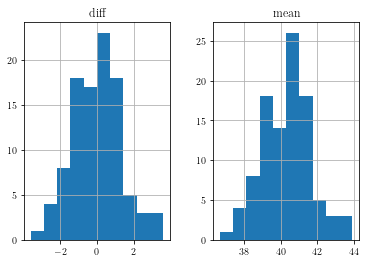

In [27]:
start = timer()

data = pd.Series([30, 37, 36, 43, 42, 43, 43, 46, 41, 42])
display(data.mean())

x = np.array([])
for i in range(100):
    if not i:
        x = np.array(data.sample(len(data.index), replace=True).values)
    else:
        x = np.vstack([x, np.array(data.sample(len(data.index), replace=True).values)])
df = pd.DataFrame(x).transpose()

def agg_ci(data, confidence=0.95):
    stats = data.agg(['mean']).transpose()
    return stats

df = agg_ci(df)
df['diff'] = df.apply(lambda x: x['mean'] - 40.3, axis=1)
df = df.sort_values(by=['diff'])
alpha = 0.95
lower = (1-alpha)/2
upper = alpha+lower
print(df.iloc[int(lower * len(df.index))])
print(df.iloc[int(upper * len(df.index))])
display(df.hist())

end = timer()
print(end - start)